# Week 7 Seminar: Logistic Regression with text

###Matric-Vector multiplication

In our model building so far we have been generating our predicted values by taking the dot product of vectors of weights and vectors of features (and adding the bias). However we want to move on to using more features than just 2. When we have lots of features, it is more efficient to handle the sets of j features for k items as a k x j matrix rather than as j vectors of length k. To combine our weights and our features we then need to take the dot product of each row of our feature matrix with our vector of weights. As you saw in this week's lecture we can take the dot product between a matrix with j columns and a row vector of length j. This can be done in numpy as follows:

**Matrix**: The matrix typically represents the weights connecting one layer of neurons to the next. Each row could correspond to a neuron in the next layer, and each column to a neuron in the previous layer. The values within the matrix are the weights that determine the strength of the connections.
<br/>
**Vector**: The vector can represent several things:
Input features: For the first layer, it's a vector of the input features for a single data sample.
Activations: For subsequent layers, it can be a vector of the activations (outputs) of the neurons in a layer.
Bias: A bias term is often added as a vector to the result of the matrix multiplication.

In [1]:
import numpy as np
vector = np.random.rand(3,1)
matrix = np.random.rand(10,3)
print(vector)
print(matrix)
# Matrix
# You can imagine each row is one example of features
# The columns would correspond to the different features of that example
# Vector
# Each column of the vector would then be the weights, or individual neurons


[[0.56874063]
 [0.24790583]
 [0.76767684]]
[[0.89295395 0.23410506 0.71046302]
 [0.49964939 0.40835768 0.9337917 ]
 [0.48406699 0.75008352 0.59606309]
 [0.73514534 0.71121232 0.03776061]
 [0.57776487 0.20820304 0.92822414]
 [0.11096045 0.68995504 0.84446738]
 [0.16114388 0.27418738 0.73725047]
 [0.03610978 0.61664659 0.73118895]
 [0.70759209 0.15772089 0.62045276]
 [0.35537428 0.2047933  0.15219186]]


In [2]:
matrix.dot(vector) # or matrix@vector

array([[1.1113012 ],
       [1.10225542],
       [0.91884247],
       [0.62340865],
       [1.09278927],
       [0.88242964],
       [0.72559183],
       [0.7347242 ],
       [0.91784351],
       [0.36971941]])

Remember that in matrix multiplication order is important. The matrix here cannot be left multiplied by the vector because its number of rows does not equal the number of elements in the vector. And so the following doesn't work:

In [3]:
vector.dot(matrix)

ValueError: shapes (3,1) and (10,3) not aligned: 1 (dim 1) != 10 (dim 0)

### Logistic regression with text: sentiment analysis

The dataset we are going to use here is 10000 reviews on Yelp classified as negative (1 or 2 star) or positive (3 or 4 star). We are going to train a classifier using this a part of this data and test its performance on another part.

First we download the dataset:

In [4]:
!wget https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/data/yelp_reviews.txt

--2025-11-10 14:20:23--  https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/data/yelp_reviews.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7005742 (6.7M) [text/plain]
Saving to: ‘yelp_reviews.txt’

yelp_reviews.txt    100%[===================>]   6.68M  --.-KB/s    in 0.06s   

2025-11-10 14:20:23 (119 MB/s) - ‘yelp_reviews.txt’ saved [7005742/7005742]



The dataset is in a tab-delimited file, so that the first element on each row is a review and then there is a tab and then the sentiment rating.

We read it into to lists (one for reviews; one for labels) as follows:

In [6]:
!head -n4 yelp_reviews.txt

review	label
all i can say is that a i had no other option then to go with time warner cable for my internet service n nand b . . . . n nif you don t have a local number it will be an absolute nightmare to pay your bill ! you can go through the ring of automated messages only to get to a live person after min then be told they will charge you so you must go through the automated service . . . . repeat . i cringe when it comes time to pay my bill each month . n nif you are lucky enough to avoid using them i suggest you do so ! 	negative
i went here once when my long time stylist moved further and further away and cut her hours to one day per week . it was nearby , they had stylists that use my color line goldwell , and the place looked nice enough . unfortunately , after a hour apppointment i had booked and only planned for an hour and a half , i walked away with the worst color job and cut i ve had in a long time . even though i gave the stylist my formula . . and he said he thought my

In [7]:
# Create lists
reviews=[]
labels=[]

with open("yelp_reviews.txt") as f:
   # iterate over the lines in the file
   for line in f.readlines()[1:]:
        # split the current line into a list of two element - the review and the label
        fields = line.rstrip().split('\t')
        # put the current review in the reviews list
        reviews.append(fields[0])
        # put the current sentiment rating in the labels list
        labels.append(fields[1])



We are going to represent our data using one-hot encoding. We need to use the same vocabulary for our training and test data so we do this prior to splitting the data.

In order to one-hot encode we need to create a list of the included vocabulary items. We will use the 5000 most frequent words (not an ideal solution but a convenient one). To get this list we extract all the words from all the reviews, count how often they occur, sort them and then take the most frequent 5000 words. To count the words we are going to use the Counter object from the collections module.

In [8]:
from collections import Counter
import re
# Tokenise the text, turning a list of strings into a list of lists of tokens. We use very naive space-based tokenisation.
tokenized_sents = [re.findall("[^ ]+",txt) for txt in reviews]
# Collapse all tokens into a single list
tokens=[]
for s in tokenized_sents:
      tokens.extend(s)
# Count the tokens in the tokens list. The returns a list of tuples of each token and count
counts=Counter(tokens)
# Sort the tuples. The reverse argument instructs to put most frequent first rather than last (which is the default)
so=sorted(counts.items(), key=lambda item: item[1], reverse=True)
# Extract the list of tokens, by transposing the list of lists so that there is a list of tokens a list of counts and then just selecting the former
so=list(zip(*so))[0]
# Select the firs 5000 words in the list
type_list=so[0:5000]

In [ ]:
type_list

We are now ready to one-hot encode our reviews. We have 10000 reviews and a selected vocabulary of 5000 words. We therefore want to end up with 10000 x 5000 matrix **M**, where each row $i$ is a review, each column $j$ is a unique word from the vocab, and each element $x_{i,j}$ is a one if the word j occurs in review i and a zero otherwise.

Problem 1: Create M

In [10]:
# Create a 10000 x 5000 matrix of zeros
M = np.zeros((len(reviews), len(type_list)))
#iterate over the reviews
for i, rev in enumerate(reviews):
  for(j,word) in enumerate(type_list):
    if word in rev:
      M[i,j]=1



In [11]:
M

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

Now we are ready to split our data. We are going to use 20% of our data as test items, so we randomly select 8000 indices between 0 and 10000, which are the indices of our training items. The remaining 2000 indices are the indices of our test items.

In a real development task we would want to split data into training, development and test. Here we just use training and test.

In [12]:
train_ints=np.random.choice(len(reviews),int(len(reviews)*0.8),replace=False)
test_ints=list(set(range(0,len(reviews))) - set(train_ints))

We next use the indices to select the rows of our one-hot-encoded matrix M that correspond to our training items and our test items and put these into two separate matrices. We also select the corresponding labels.

In [14]:
M_train = M[train_ints,]
M_test = M[test_ints,]
labels_train = [labels[i] for i in train_ints]
labels_test = [labels[i] for i in test_ints]

In [18]:
M_train

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

Now we are ready to train our model using the training data.

Problem 2 Complete the code below so that it learns a logistic regression model from the training data.

Text(0, 0.5, 'loss')

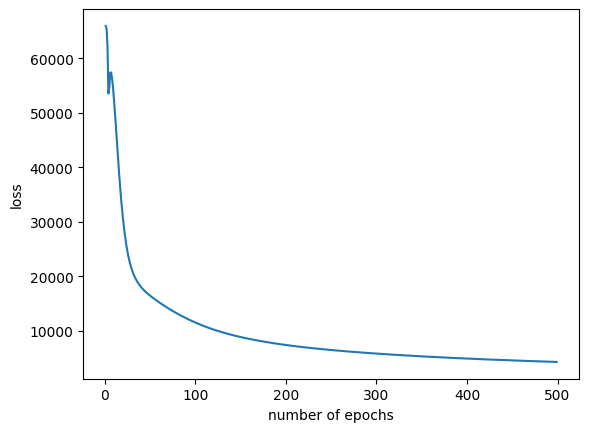

In [23]:
import math
import matplotlib.pyplot as plt

num_features=5000
y=[int(l == "positive") for l in labels_train]
weights = np.random.rand(num_features)
bias=np.random.rand(1)
n_iters = 500
lr=0.4
logistic_loss=[]
num_samples=len(y)
for i in range(n_iters):
  # Basically you are multiplying all the values of M_train with the weights
  # It would be similar to this: z= bias + (x[0]*weights[0] + x[1]*weights[1])
  z= M_train.dot(weights) + bias
  # print(z)
  # (1 / (1+np.exp(-z))) we use sigmoid because we only need to know whether it is positive or negative, two possible values
  q = (1 / (1+np.exp(-z)))
  # print(q)
  eps=0.00001
  loss = -sum((y*np.log2(q+eps)+(np.ones(len(y))-y)*np.log2(np.ones(len(y))-q+eps)))
  logistic_loss.append(loss)
  # We then make the prediction, if it is below a certain number, 0.5 it is negative and vice versa
  y_pred=[int(ql > 0.5) for ql in q]

  # For logistic regression one shot encoder= dw1 = np.dot(x[0],q-y)/num_samples
  dw = (q-y).dot(M_train)/num_samples
  db = sum(q-y)/num_samples
  weights = weights - dw*lr
  bias = bias - db*lr

plt.plot(range(1,n_iters),logistic_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")
#loss = sum(-(np.ones(len(y))*np.log2(q)+(np.ones(len(y))-y)*np.log2(np.ones(len(y))-q)))

Now that we have a fitting model, we can use it to predict labels for our test items. The test reviews are in the one-hot matrix M_test. The labels for the test reviews are in the list labels_test.

Problem 3: Complete the code below so that it calculate the vector of predicted values y_test_pred for our test items.

In [26]:
z= M_test.dot(weights) + bias
q = (1 / (1+np.exp(-z)))
y_test_pred=[int(ql > 0.5) for ql in q]

We can calculate accuracy for the performance of our model on the test items as follows:

In [27]:
y_test=[int(l == "positive") for l in labels_test]
acc_test=[int(yp == y_test[s]) for s,yp in enumerate(y_test_pred)]
print(sum(acc_test)/len(acc_test))

0.83


Remember though that precision is not usually a good measure and so we calculate precision and recall.

Problem 4 : Calculate precision and recall values for the performance of our model on the test data. I have given code for calculating the true positive rate. You will need to calculate the rest of the values from the confusion matrix and then use these numbers to calculate our evaluation metrics.

In [ ]:
labels_test_pred=["positive" if s == 1 else "negative" for s in y_test_pred]

In [ ]:
true_positives=sum([int(yp == "positive" and labels_test[s] == "positive") for s,yp in enumerate(labels_test_pred)])

Problem 5: Calculate precision and recall values for the performance of the model on the training data. How do the numbers differ from those you found for the test set? Why do you think this is?

### Inspecting weights
Weights in a one-layer network with one-hot encoded inputs are simple to interpret - words with high weights are those whose presence makes a positive outcome most likely and those with low weights are those whose presence makes a negative outcome most likely.

Our weights are in a numpy array, with each weight corresponding the word at the same position (index) in our type_list.

 We can obtain a list of the indices in order to the weight at each position using the numpy function argsort. This sorts from low to high so we take the top 10 to find the indices of the ten words most strongly associated with a negative outcome. Or we can reverse it to find the indices of the ten words most strongly associated with a positive outcome.

 We can ten just look at the words that occur at these indices:

In [28]:
[type_list[x] for x in np.argsort(weights)[0:20]]

['rib',
 'age',
 '?',
 'less',
 'con',
 'over',
 'not',
 'why',
 'point',
 'um',
 'mon',
 'said',
 'worst',
 'ass',
 'nin',
 'used',
 'where',
 'bad',
 'ted',
 'ok']

In [29]:
[type_list[x] for x in np.argsort(weights)[::-1][0:20]]

['great',
 'amazing',
 'definitely',
 'yum',
 'fantastic',
 '!',
 'delicious',
 'best',
 'favorite',
 'perfectly',
 'awesome',
 'vegas',
 'incredible',
 'love',
 'funny',
 'wonderful',
 'minor',
 'strip',
 'def',
 'deli']

Problem 6a: Inspect the list of tokens with highest and lowest weights, going beyond the top and bottom 10. Do you spot any that indicate overfitting?

Problem 6b: Look back up to the first code block above where we create the one-hot encoded data. Can you change the way the text is tokenised in order to avoid the problematic tokens you noted in 6a? Retrain the model. How do your changes affect performance / the token lists?


In [ ]:
# Top negative words beyond the top and bottom 10
